In [18]:
# для автозагрузки изменений в модулях без необходимости перезагрузки kelner
%load_ext autoreload
%autoreload 2

# необходимо для корректного импорта своих модулей в JupyterLab
import sys
current_dir = sys.path[0]
project_dir = 'SF_DS_Pro'
last_position = current_dir.find(project_dir) + len(project_dir)
project_path = current_dir[:last_position]
sys.path.append(project_path)

import Handlers as hd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn import set_config
set_config(transform_output = 'pandas')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# sns.set_theme('notebook')
sns.set_palette('Set2')

plt.rcParams['figure.figsize'] = (12, 8)

In [20]:
df = pd.read_csv('data/AirPassengers.zip', parse_dates=['Month'], index_col='Month')
df

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


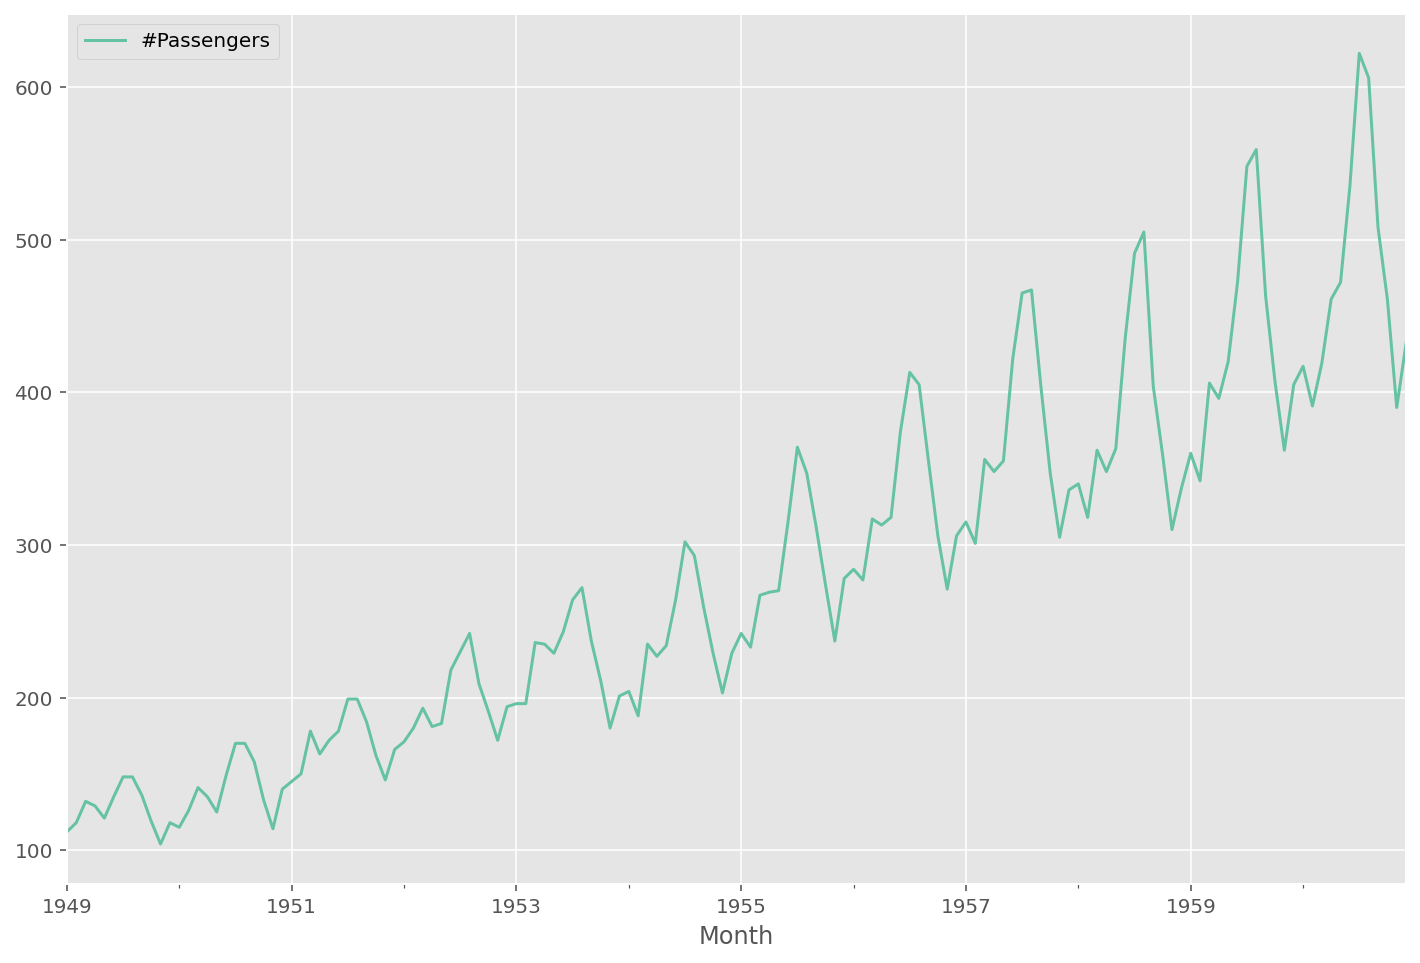

In [21]:
df.plot();

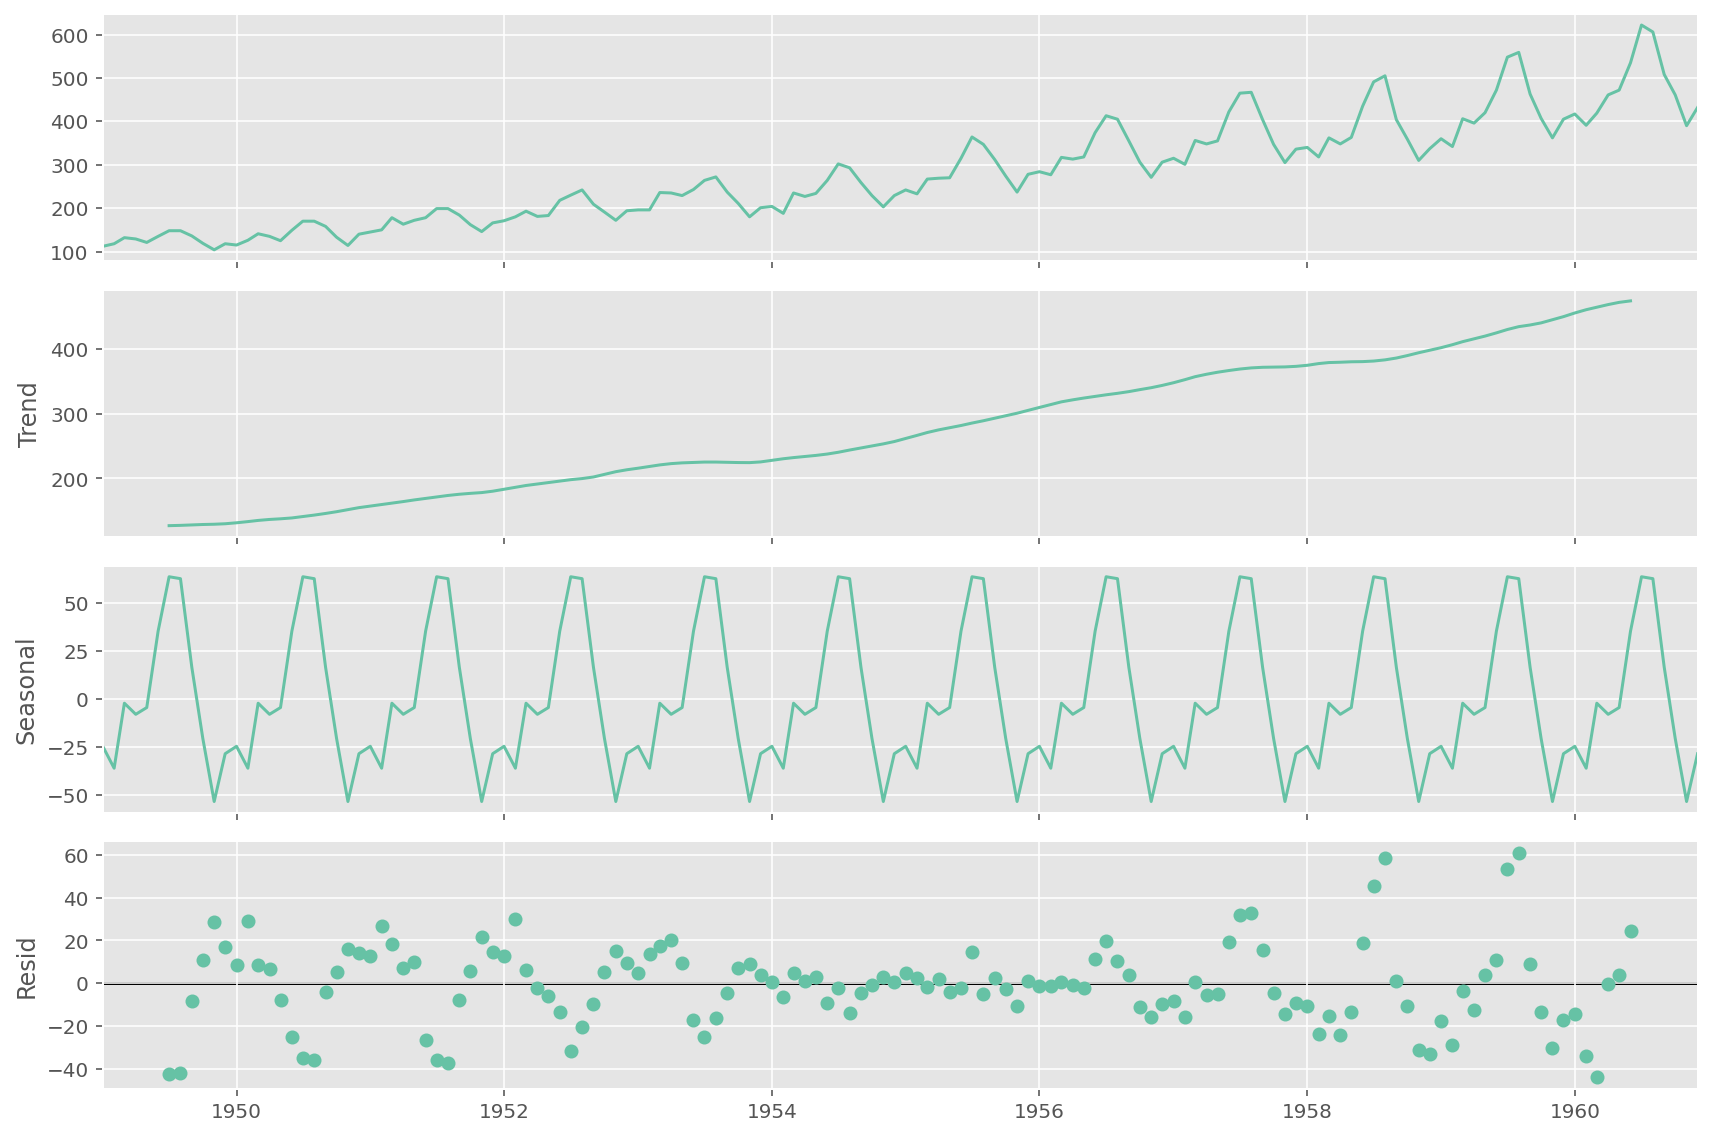

In [22]:
# импортируем библиотеку 
from statsmodels.tsa.seasonal import seasonal_decompose
# производим декомпозицию временного ряда 
decomposition = seasonal_decompose(df)
fig = decomposition.plot()
plt.show()

### Экспоненциальное сглаживание

In [23]:
def exp_smth(x_t, a, s_t_1):
    return a * x_t + (1 - a) * s_t_1

data = np.array([15, 20, 25, 30, 25, 27])
a = 0.7
s = np.zeros(6)
s[0] = data[0]

for i in range(1, len(data)):
    s[i] = exp_smth(data[i], a, s[i-1])

print(s)

[15.      18.5     23.05    27.915   25.8745  26.66235]


In [24]:
from statsmodels.tsa.api import SimpleExpSmoothing

ses = SimpleExpSmoothing(data)
alpha = 0.7
model = ses.fit(smoothing_level=alpha, optimized=False)

forecast = model.forecast(1)
print(forecast)

[26.66235]


### Стационарность

In [25]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

df = pd.read_csv('data/daily-total-female-births.zip', 
                 header=0, index_col=0).squeeze("columns")

result = adfuller(df.values)

print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print("Critical Values:")

for key, value in result[4].items():
	print(f"\t{key}: {value:.3f}")

ADF Statistic: -4.808291253559763
p-value: 5.243412990149865e-05
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


In [26]:
hd.adf(df.values, 0.01)

Test-Statistic: -4.808291253559763
P-Value: 5.243412990149865e-05
Time series is stationary!


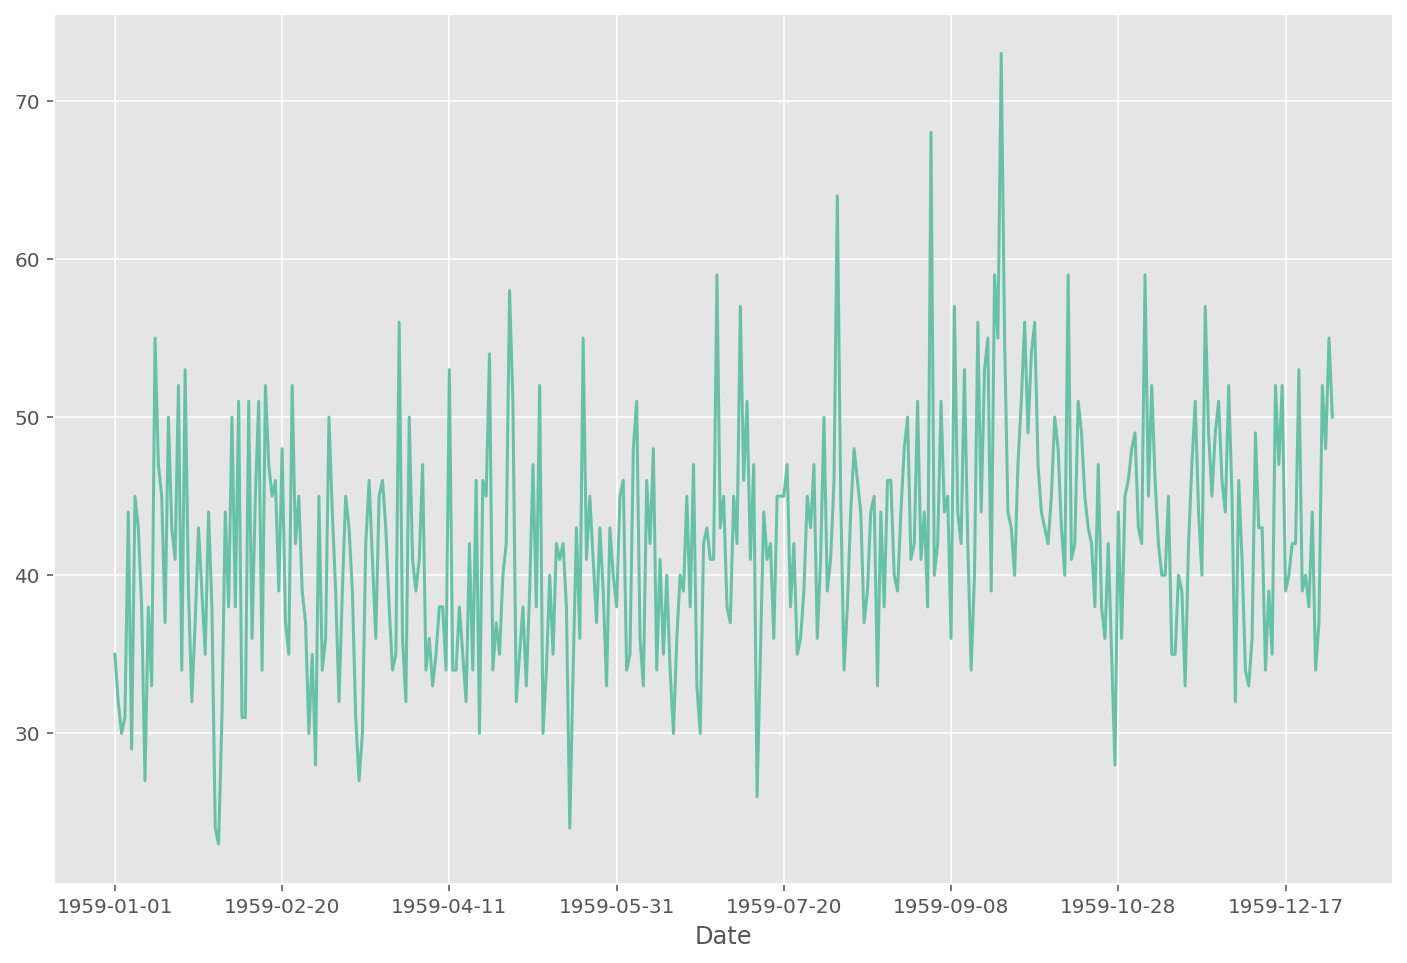

In [27]:
df.plot();

### Автокорреляция

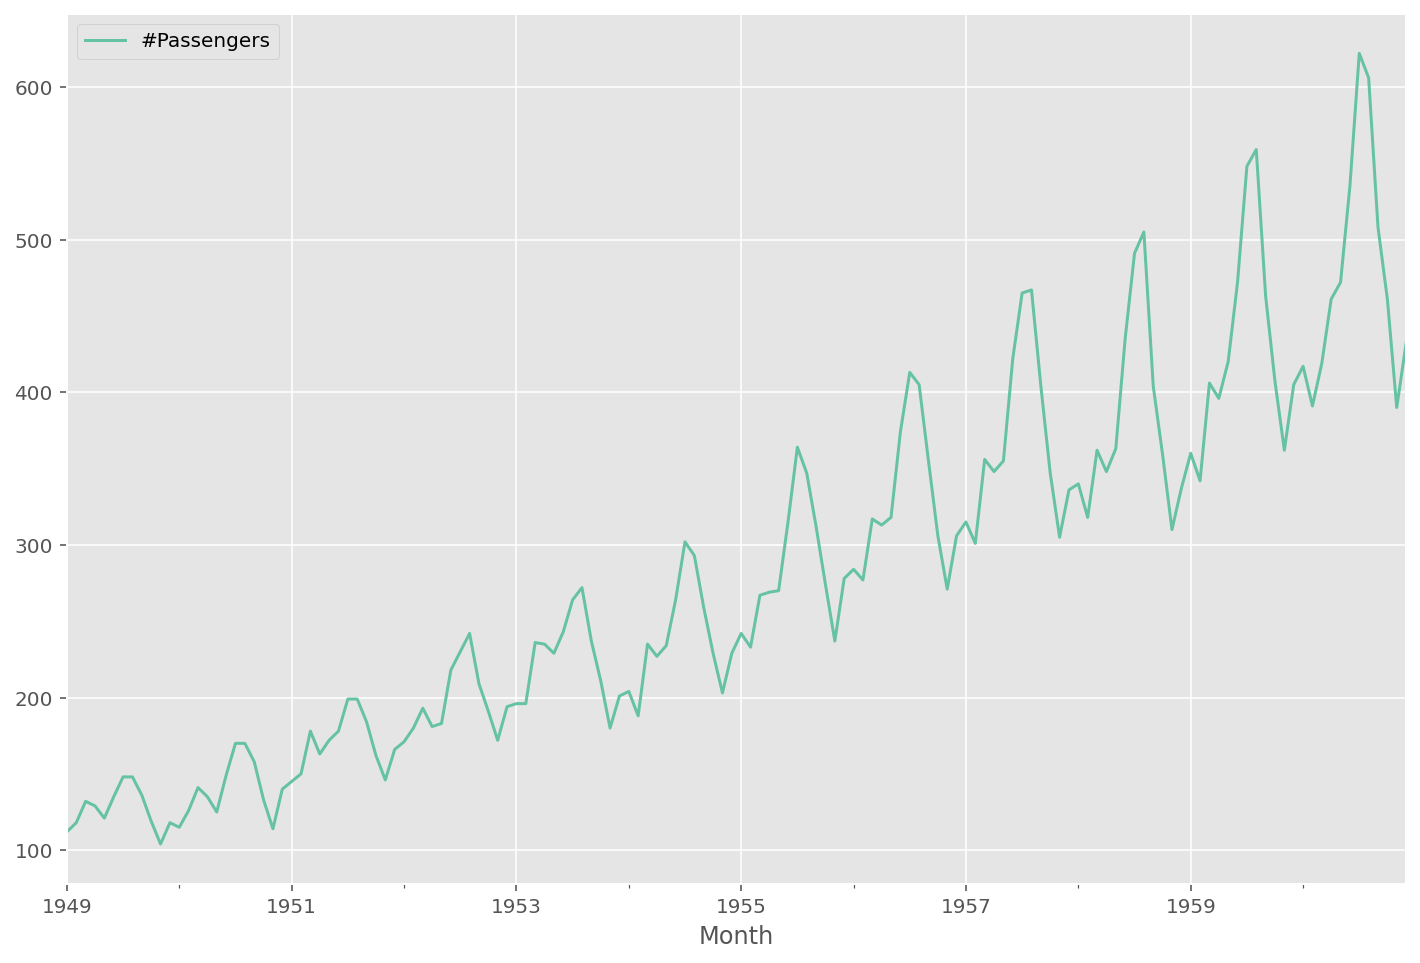

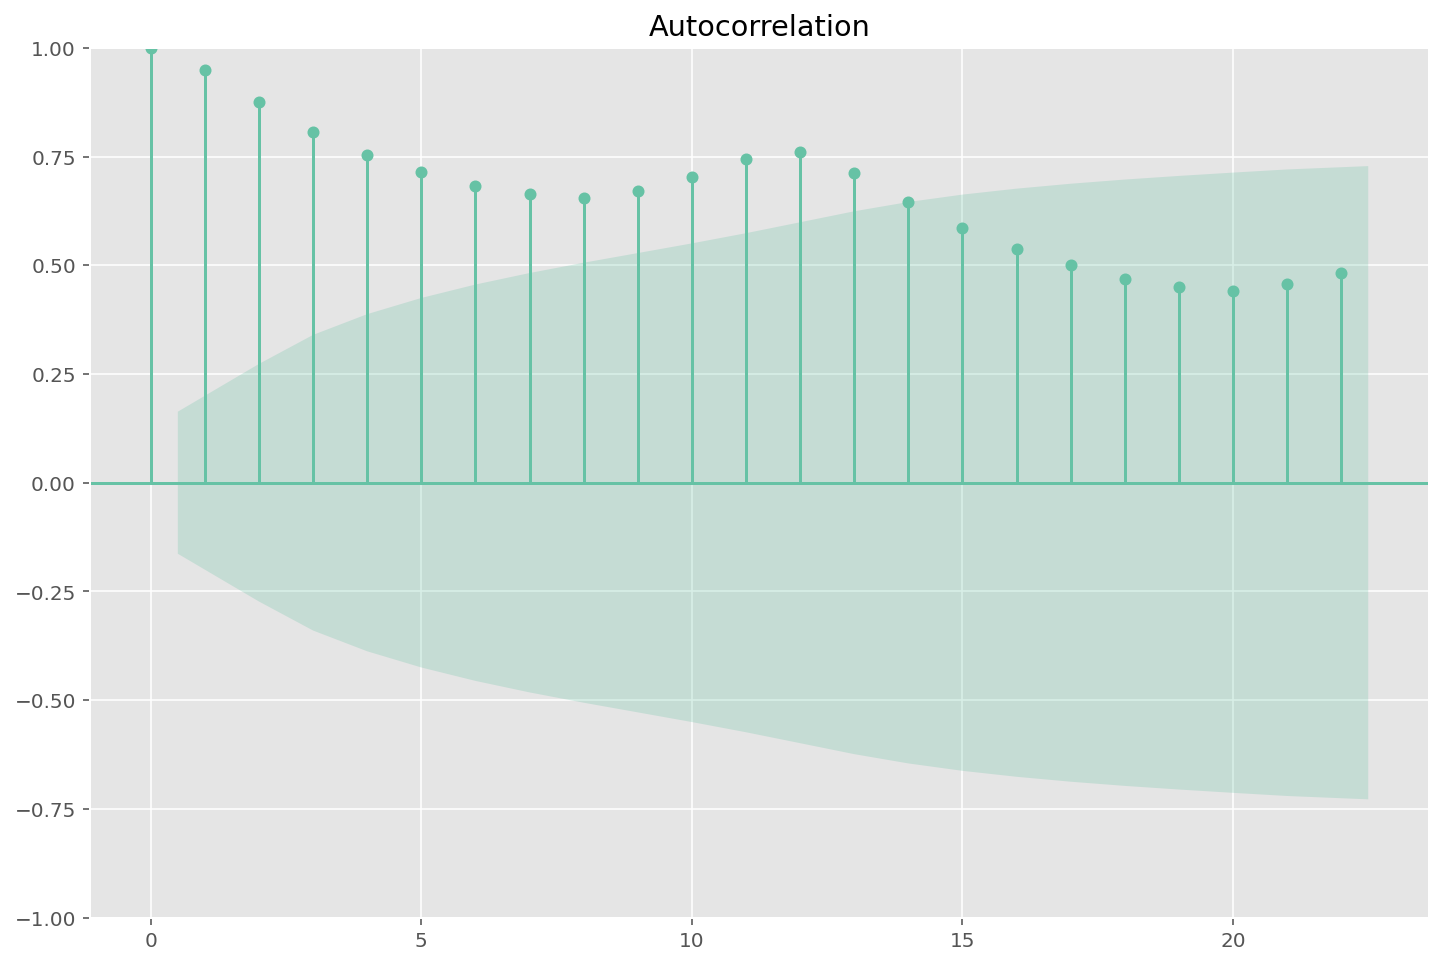

In [28]:
from statsmodels.graphics.tsaplots import plot_acf

df = pd.read_csv('data/AirPassengers.zip', index_col='Month', parse_dates=['Month'])
df.plot();
plot_acf(df['#Passengers']);

Стационарный ряд и изменения автокорреляции

In [29]:
df_diff2 = df.diff().diff().dropna()

Только двойное дифференцирование привело к тому, что ряд стал стационарным.

In [30]:
hd.adf(df_diff2['#Passengers'].values, 0.05)

Test-Statistic: -16.384231542468505
P-Value: 2.7328918500142407e-29
Time series is stationary!


In [31]:
df_log = df.copy()
df_log['#Passengers'] = np.log(df_log['#Passengers'])

In [32]:
df_log_diff1 = df_log.diff().dropna()

In [33]:
hd.adf(df_log_diff1['#Passengers'].values, 0.05)

Test-Statistic: -2.717130598388133
P-Value: 0.07112054815085875
Time series is non-stationary


<Axes: xlabel='Month'>

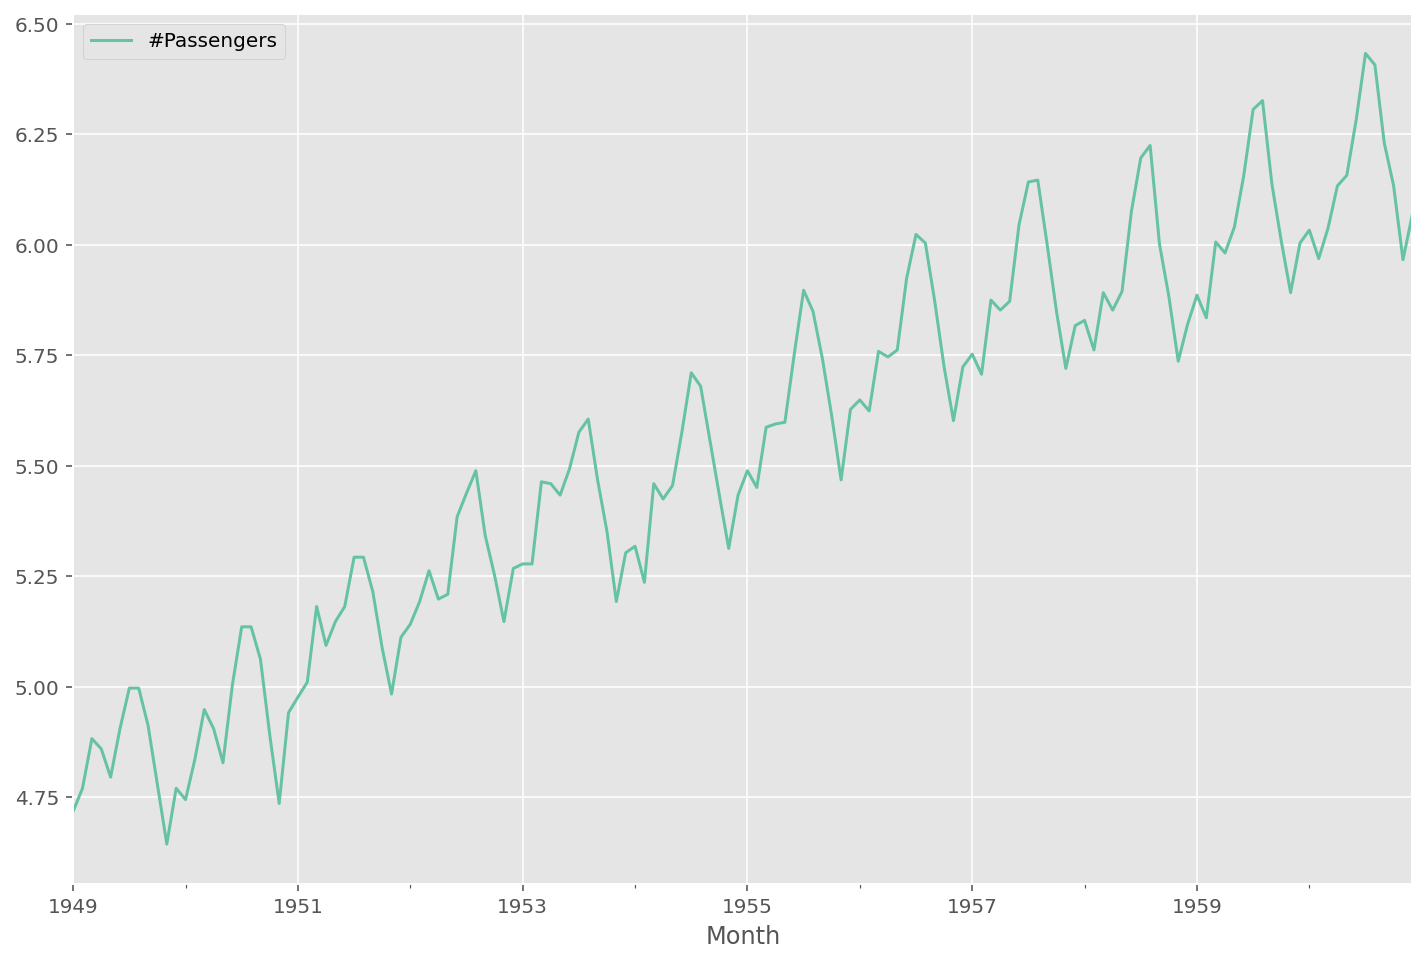

In [34]:
df_log.plot()

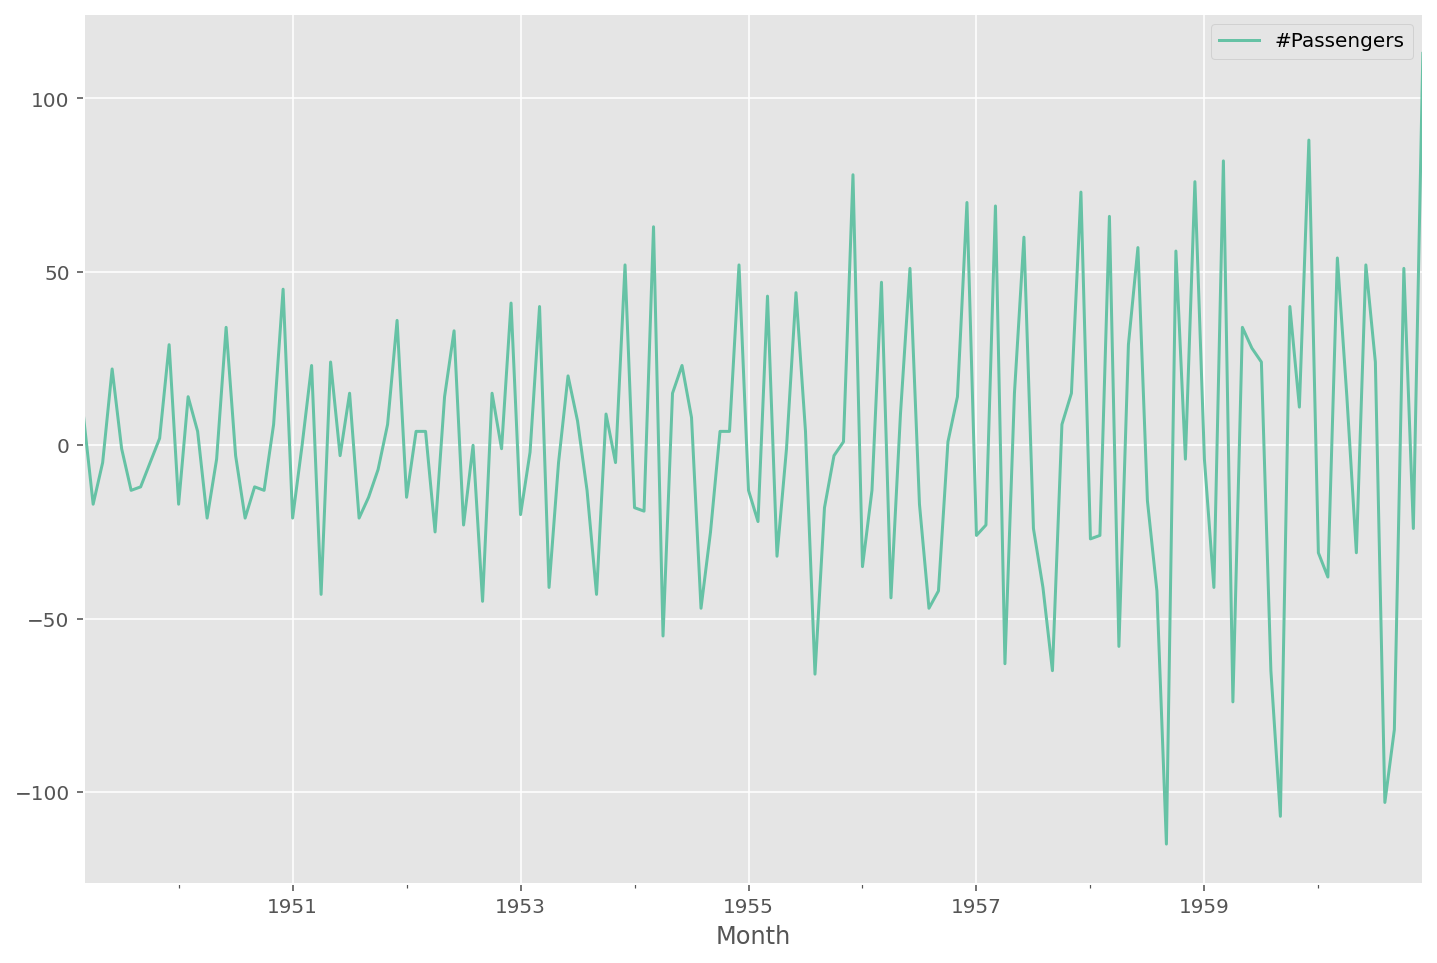

In [35]:

df_diff2.plot();

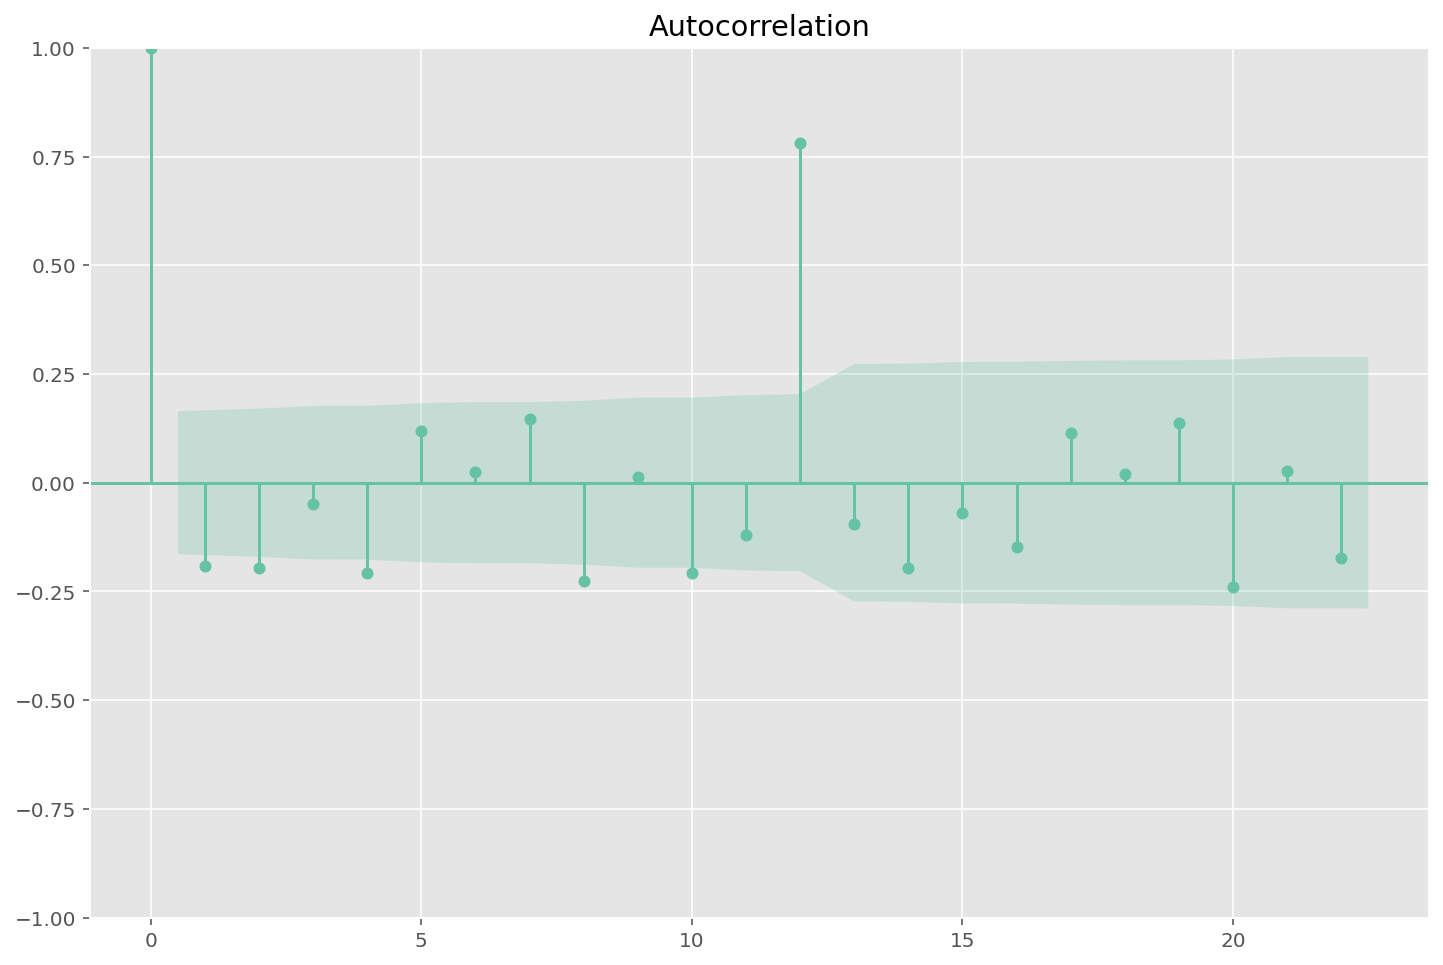

In [36]:
plot_acf(df_diff2['#Passengers']);

### AR-моделирование

In [40]:
from statsmodels.tsa.ar_model import AutoReg

# url='https://raw.githubusercontent.com/jenfly/opsd/master/opsd_germany_daily.csv'
df = pd.read_csv('data/jenfly_opsd_master_opsd_germany_daily.csv', sep=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4383 entries, 0 to 4382
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         4383 non-null   object 
 1   Consumption  4383 non-null   float64
 2   Wind         2920 non-null   float64
 3   Solar        2188 non-null   float64
 4   Wind+Solar   2187 non-null   float64
dtypes: float64(4), object(1)
memory usage: 171.3+ KB


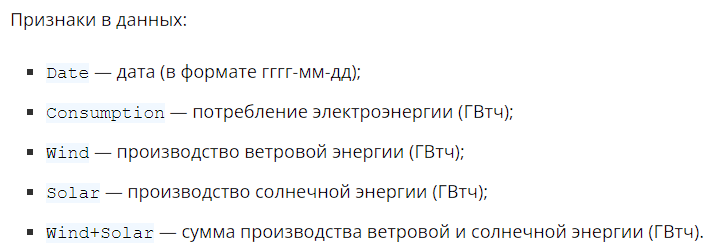

В качестве примера построим предсказание объёма потребления электроэнергии на три месяца (возьмём последние 100 дней).

In [41]:
df

,Date,Consumption,Wind,Solar,Wind+Solar
0,2006-01-01,1069.18400,NaN,NaN,NaN
1,2006-01-02,1380.52100,NaN,NaN,NaN
2,2006-01-03,1442.53300,NaN,NaN,NaN
3,2006-01-04,1457.21700,NaN,NaN,NaN
4,2006-01-05,1477.13100,NaN,NaN,NaN
...,...,...,...,...,...
4378,2017-12-27,1263.94091,394.507,16.530,411.037
4379,2017-12-28,1299.86398,506.424,14.162,520.586
4380,2017-12-29,1295.08753,584.277,29.854,614.131
4381,2017-12-30,1215.44897,721.247,7.467,728.714


При использовании статистических моделей временные ряды нельзя делить на обучающую и тестовую выборки случайным образом. Так как нам важно сохранять последовательность, разделим данные на обучающую и тестовую выборки упорядоченно, то есть возьмём в качестве тестовой выборки последние 100 значений. Остальные данные будем использовать для обучения.

In [43]:
ind_train_test = len(df)-100
train_data = df['Consumption'][:ind_train_test]
test_data = df['Consumption'][ind_train_test:]

Инициализируем и обучим модель. Возьмём lags=8 (AR(8)) — на практике же будем определять это значение по графику частичной автокорреляции:

In [44]:
ar_model = AutoReg(train_data, lags=8).fit()
print(ar_model.summary())

                            AutoReg Model Results                             
Dep. Variable:            Consumption   No. Observations:                 4283
Model:                     AutoReg(8)   Log Likelihood              -24231.812
Method:               Conditional MLE   S.D. of innovations             70.058
Date:                Wed, 26 Jul 2023   AIC                          48483.625
Time:                        11:30:03   BIC                          48547.230
Sample:                             8   HQIC                         48506.095
                                 4283                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            121.2792     14.444      8.397      0.000      92.969     149.589
Consumption.L1     0.6393      0.013     47.751      0.000       0.613       0.666
Consumption.L2    -0.0966      0.011

Сделаем предсказание. Метод predict требует два обязательных параметра — метки начала и окончания предсказания. 

Метка начала предсказания будет равна количеству данных в обучающей выборке, так как нас интересует прогноз со следующего дня. 

Метка окончания в нашем случае будет равна len(train_data)+100, что эквивалентно len(df)-1, так как len(df) = len(train_data) + len(test_data).

In [45]:
pred = ar_model.predict(start=len(train_data), end=(len(df)-1), dynamic=False)